# Set Cover problem

In [847]:
import numpy as np
from itertools import accumulate
from matplotlib import pyplot as plt
from icecream import ic

## Set Cover Problem - Global code


In [848]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [849]:
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [850]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness_plot(fitness_values):
    plt.figure(figsize=(14, 8))
    plt.plot(
       range(len(fitness_values)),
       list(accumulate(fitness_values, max)),
       color="red",
    )
    _ = plt.scatter(range(len(fitness_values)), fitness_values, marker=".")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.title("Hill Climbing Fitness Over Iterations")
    plt.show()

## First dumb solutions

In [851]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(841074235.0327284))

In [852]:
# A random solution with random 50% of the sets
solution = np.random.random(NUM_SETS) < 1
valid(solution), cost(solution)

(np.True_, np.float64(841074235.0327284))

## Hill Climbing - Single random mutation

In [853]:
# First simple tweak: add/remove a random set
# SINGLE MUTATION
def tweak_1(solution):
    """Tweaks a solution by adding/removing a random set"""
    new_solution = solution.copy()
    index = rng.integers(NUM_SETS)
    new_solution[index] = not new_solution[index]
    return new_solution

# Fitness function that returns a tuple of (validity, cost)
def fitness(solution):
    """Returns the fitness of a solution"""
    return (valid(solution), -cost(solution))

# Starting point: all sets taken
def starting_point():
    return rng.random(NUM_SETS) < 1

# Define a fixed number of steps as a stopping criterion
def stopping_criterion():
    NUM_STEPS = 100
    return range(NUM_STEPS)

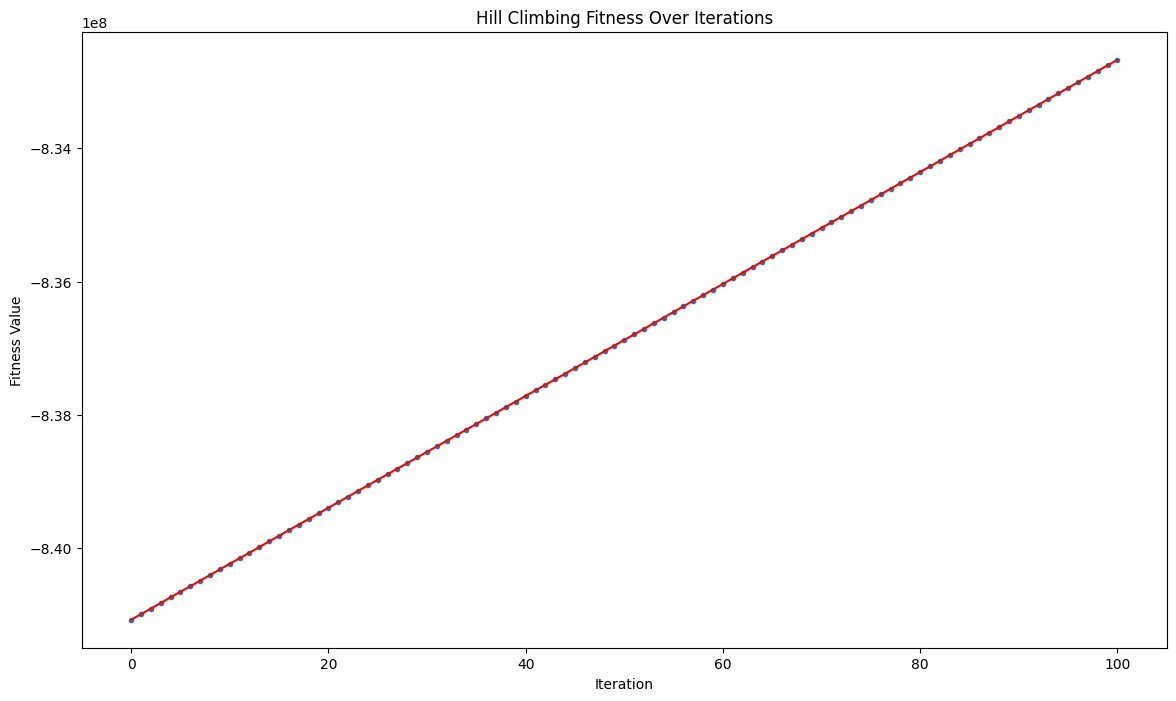

(np.True_, np.float64(832669532.4770744))

In [854]:


# A simple hill-climbing algorithm
def hill_climbing(tweak):
    solution = starting_point()
    history = [fitness(solution)]
    for _ in stopping_criterion():
        new_solution = tweak(solution)
        history.append(fitness(new_solution))
        if fitness(new_solution) > fitness(solution):
            solution = new_solution
    return solution, history


s, history = hill_climbing(tweak_1)

fitness_values = [c for _, c in history]
fitness_plot(fitness_values)

valid(s), cost(s)

## Hill Climbing - Multiple random mutations

In [855]:
# Improved tweak: iterate with a 40% of chance of a new step
# MULTPLE MUTATIONS 
def tweak_2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or rng.random() < 0.4:
        index = rng.integers(NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution


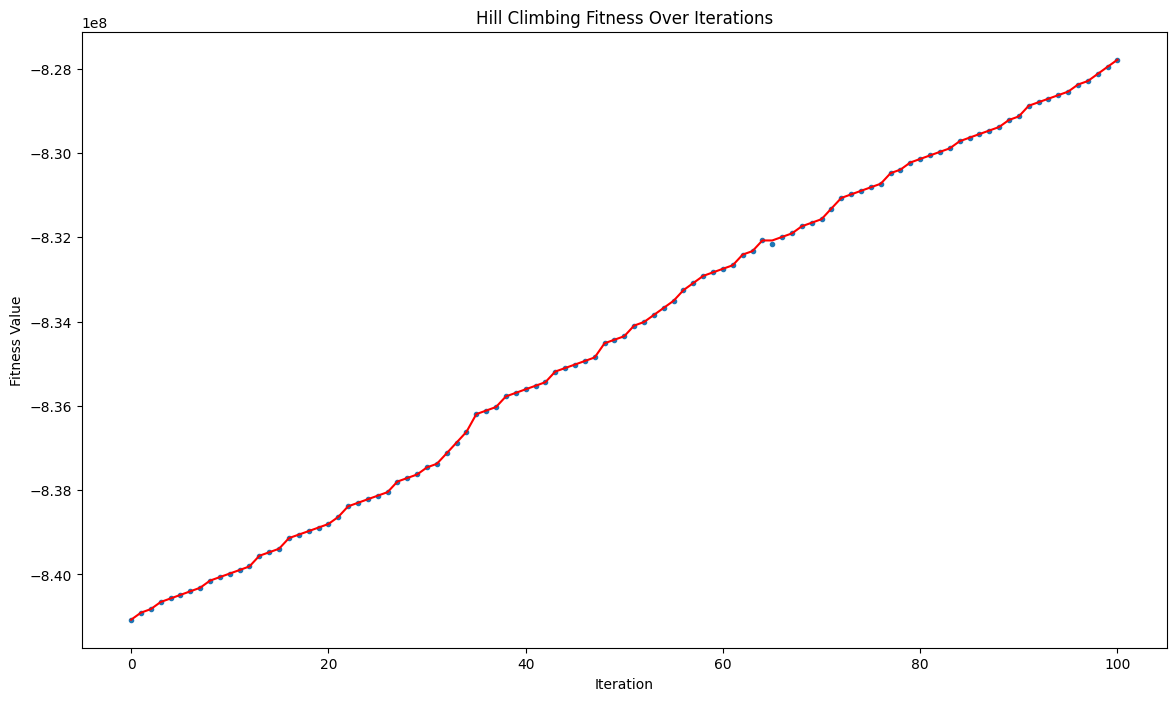

(np.True_, np.float64(827786465.7768534))

In [856]:
s, history = hill_climbing(tweak_2)

fitness_values = [c for _, c in history]
fitness_plot(fitness_values)

valid(s), cost(s)

## Hill climbing - Steepest Step and Restart

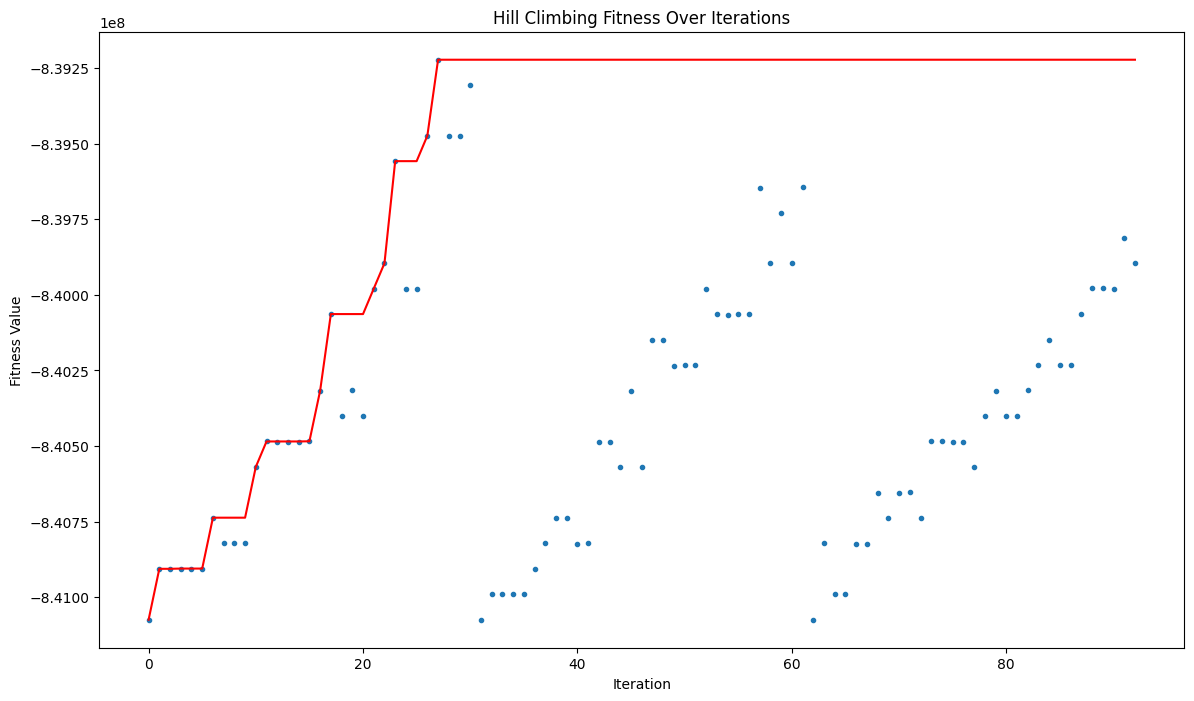

(np.True_, np.float64(839222691.9478567))

In [857]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = max(stopping_criterion()) // STEEPEST_STEP_CANDIDATES

def steepest_step(solution, history, tweak=tweak_2):
    # Finds the best tweak among a set of candidates
    best_solution = solution
    best_fitness = fitness(solution)
    for _ in range(STEEPEST_STEP_CANDIDATES):
        candidate = tweak(solution)
        candidate_fitness = fitness(candidate)
        history.append(candidate_fitness)
        if candidate_fitness > best_fitness:
            best_solution = candidate
            best_fitness = candidate_fitness
    return best_solution

def hill_climbing_with_restarts():
    # Performs hill climbing with multiple restarts
    best_solution = None
    best_fitness = (False, float('-inf'))
    history = list()

    for _ in range(NUM_RESTARTS):
        solution = starting_point()
        history.append(fitness(solution))
        for _ in range(TRUE_MAX_STEPS // NUM_RESTARTS):
            new_solution = steepest_step(solution, history)
            if fitness(new_solution) > fitness(solution):
                solution = new_solution
        if fitness(solution) > best_fitness:
            best_solution = solution
            best_fitness = fitness(solution)
    return best_solution, history


s, history = hill_climbing_with_restarts()

fitness_values = [c for _, c in history]
fitness_plot(fitness_values)

valid(s), cost(s)
